# Phase I: Base Model

## Import Models

In [1]:
import pandas as pd
import numpy as np

# Models
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Load and preprocess data

In [2]:
df = pd.read_csv("mushrooms.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [4]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [5]:
# Encode all categorical columns
le = LabelEncoder()
for col in df.columns:
    df[col] = le.fit_transform(df[col])

In [6]:
# Features and target
X = df.drop("class", axis=1)
y = df["class"]

## Train-test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Base models

In [8]:
models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(),
    "XGBoost": XGBClassifier()
}

In [9]:
results = []
for name, model in models.items():
    # Fit
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    results.append([name, train_acc, test_acc])

In [10]:
# Convert to DataFrame for nice display
acc_df = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy"])
print(acc_df)

                 Model  Train Accuracy  Test Accuracy
0        Random Forest        1.000000       1.000000
1                  SVM        0.990614       0.992000
2  Logistic Regression        0.950454       0.957538
3              XGBoost        1.000000       1.000000


## Ensemble Methods (on full train/test)

### Hard Voting

In [11]:
hard_voting = VotingClassifier(
    estimators=[
        ("rf", models["Random Forest"]),
        ("svm", models["SVM"]),
        ("lr", models["Logistic Regression"]),
        ("xgb", models["XGBoost"])
    ],
    voting="hard"
)

In [12]:
hard_voting.fit(X_train, y_train)
y_pred_hard = hard_voting.predict(X_test)
print("\nHard Voting Accuracy:", accuracy_score(y_test, y_pred_hard))
print(classification_report(y_test, y_pred_hard))


Hard Voting Accuracy: 0.9932307692307693
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       842
           1       1.00      0.99      0.99       783

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



### Soft Voting

In [13]:
soft_voting = VotingClassifier(
    estimators=[
        ("rf", models["Random Forest"]),
        ("svm", models["SVM"]),
        ("lr", models["Logistic Regression"]),
        ("xgb", models["XGBoost"])
    ],
    voting="soft"
)

In [14]:
soft_voting.fit(X_train, y_train)
y_pred_soft = soft_voting.predict(X_test)
print("\nSoft Voting Accuracy:", accuracy_score(y_test, y_pred_soft))
print(classification_report(y_test, y_pred_soft))


Soft Voting Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



### Stacking

In [15]:
stacking = StackingClassifier(
    estimators=[
        ("rf", models["Random Forest"]),
        ("svm", models["SVM"]),
        ("xgb", models["XGBoost"])
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

In [16]:
stacking.fit(X_train, y_train)
y_pred_stack = stacking.predict(X_test)
print("\nStacking Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))


Stacking Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



## Cross Validation (K-fold)

In [17]:
all_models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(),
    "XGBoost": XGBClassifier(),
    "Hard Voting": hard_voting,
    "Soft Voting": soft_voting,
    "Stacking": stacking
}

In [18]:
print("\n=== Final Cross-Validation (10-Fold) Results ===")

for name, model in all_models.items():
    scores = cross_val_score(model, X, y, cv=10, scoring="accuracy")
    print(f"{name}: Mean CV Accuracy = {scores.mean():.4f} (+/- {scores.std():.4f})")


=== Final Cross-Validation (10-Fold) Results ===
Random Forest: Mean CV Accuracy = 0.9625 (+/- 0.0942)
SVM: Mean CV Accuracy = 0.9172 (+/- 0.1289)
Logistic Regression: Mean CV Accuracy = 0.8800 (+/- 0.1283)
XGBoost: Mean CV Accuracy = 0.9654 (+/- 0.0939)
Hard Voting: Mean CV Accuracy = 0.9483 (+/- 0.0916)
Soft Voting: Mean CV Accuracy = 0.9334 (+/- 0.1334)
Stacking: Mean CV Accuracy = 0.9676 (+/- 0.0942)


# Phase II: Feature Selection

## Importing models

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

## Feature Selection - SelectKBest

In [20]:
k = X_train.shape[1]    # choose all features (adjust as needed)

select_kbest = SelectKBest(score_func=chi2, k=k)
X_train_kbest = select_kbest.fit_transform(X_train, y_train)
X_test_kbest = select_kbest.transform(X_test)

print(f"SelectKBest selected {X_train_kbest.shape[1]} features")

SelectKBest selected 22 features


## Feature Selection - RFE

In [21]:
base_estimator = LogisticRegression(max_iter=500, random_state=42)
rfe = RFE(base_estimator, n_features_to_select=k)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

print(f"RFE selected {X_train_rfe.shape[1]} features")

RFE selected 22 features


###  Define Models

In [22]:
models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(),
    "XGBoost": XGBClassifier()
}

## Ensembles with Select K best

### Hard Voting

In [23]:
hard_voting_kbest = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier()),
        ("svm", SVC(probability=True)),
        ("lr", LogisticRegression()),
        ("xgb", XGBClassifier())
    ],
    voting="hard"
)

In [24]:
hard_voting_kbest.fit(X_train_kbest, y_train)
y_pred_hard_kbest = hard_voting_kbest.predict(X_test_kbest)
print("\nHard Voting (SelectKBest):")
print("Accuracy:", accuracy_score(y_test, y_pred_hard_kbest))
print(classification_report(y_test, y_pred_hard_kbest))


Hard Voting (SelectKBest):
Accuracy: 0.9932307692307693
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       842
           1       1.00      0.99      0.99       783

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



### Soft Voting

In [25]:
soft_voting_kbest = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier()),
        ("svm", SVC(probability=True)),
        ("lr", LogisticRegression()),
        ("xgb", XGBClassifier())
    ],
    voting="soft"
)

In [26]:
soft_voting_kbest.fit(X_train_kbest, y_train)
y_pred_soft_kbest = soft_voting_kbest.predict(X_test_kbest)
print("\nSoft Voting (SelectKBest):")
print("Accuracy:", accuracy_score(y_test, y_pred_soft_kbest))
print(classification_report(y_test, y_pred_soft_kbest))


Soft Voting (SelectKBest):
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



### Stacking

In [27]:
stacking_kbest = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier()),
        ("svm", SVC(probability=True)),
        ("xgb", XGBClassifier())
    ],
    final_estimator=LogisticRegression(),
    cv=10
)

In [28]:
stacking_kbest.fit(X_train_kbest, y_train)
y_pred_stack_kbest = stacking_kbest.predict(X_test_kbest)
print("\nStacking (SelectKBest):")
print("Accuracy:", accuracy_score(y_test, y_pred_stack_kbest))
print(classification_report(y_test, y_pred_stack_kbest))


Stacking (SelectKBest):
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



## Ensembles with RFE features

### Hard Voting

In [29]:
hard_voting_rfe = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier()),
        ("svm", SVC(probability=True)),
        ("lr", LogisticRegression()),
        ("xgb", XGBClassifier())
    ],
    voting="hard"
)

In [30]:
hard_voting_rfe.fit(X_train_rfe, y_train)
y_pred_hard_rfe = hard_voting_rfe.predict(X_test_rfe)
print("\nHard Voting (RFE):")
print("Accuracy:", accuracy_score(y_test, y_pred_hard_rfe))
print(classification_report(y_test, y_pred_hard_rfe))


Hard Voting (RFE):
Accuracy: 0.9932307692307693
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       842
           1       1.00      0.99      0.99       783

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



### Soft Voting

In [31]:
soft_voting_rfe = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier()),
        ("svm", SVC(probability=True)),
        ("lr", LogisticRegression()),
        ("xgb", XGBClassifier())
    ],
    voting="soft"
)

In [32]:
soft_voting_rfe.fit(X_train_rfe, y_train)
y_pred_soft_rfe = soft_voting_rfe.predict(X_test_rfe)
print("\nSoft Voting (RFE):")
print("Accuracy:", accuracy_score(y_test, y_pred_soft_rfe))
print(classification_report(y_test, y_pred_soft_rfe))


Soft Voting (RFE):
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



### Stacking

In [33]:
stacking_rfe = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier()),
        ("svm", SVC(probability=True)),
        ("xgb", XGBClassifier())
    ],
    final_estimator=LogisticRegression(),
    cv=10
)

In [34]:
stacking_rfe.fit(X_train_rfe, y_train)
y_pred_stack_rfe = stacking_rfe.predict(X_test_rfe)
print("\nStacking (RFE):")
print("Accuracy:", accuracy_score(y_test, y_pred_stack_rfe))
print(classification_report(y_test, y_pred_stack_rfe))


Stacking (RFE):
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



## Cross-Validation for Ensembles

In [35]:
def evaluate_cv(model, X, y, model_name, dataset_name):
    scores = cross_val_score(model, X, y, cv=10, scoring="accuracy")
    print(f"{model_name} ({dataset_name}) - Mean CV Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

In [36]:
print("\n=== Cross Validation (10-fold) on Ensembles with SelectKBest Features ===")

evaluate_cv(hard_voting_kbest, X_train_kbest, y_train, "Hard Voting", "SelectKBest")
evaluate_cv(soft_voting_kbest, X_train_kbest, y_train, "Soft Voting", "SelectKBest")
evaluate_cv(stacking_kbest, X_train_kbest, y_train, "Stacking", "SelectKBest")


=== Cross Validation (10-fold) on Ensembles with SelectKBest Features ===
Hard Voting (SelectKBest) - Mean CV Accuracy: 0.9895 (+/- 0.0050)
Soft Voting (SelectKBest) - Mean CV Accuracy: 1.0000 (+/- 0.0000)
Stacking (SelectKBest) - Mean CV Accuracy: 1.0000 (+/- 0.0000)


In [37]:
print("\n=== Cross Validation (10-fold) on Ensembles with RFE Features ===")

evaluate_cv(hard_voting_rfe, X_train_rfe, y_train, "Hard Voting", "RFE")
evaluate_cv(soft_voting_rfe, X_train_rfe, y_train, "Soft Voting", "RFE")
evaluate_cv(stacking_rfe, X_train_rfe, y_train, "Stacking", "RFE")


=== Cross Validation (10-fold) on Ensembles with RFE Features ===
Hard Voting (RFE) - Mean CV Accuracy: 0.9895 (+/- 0.0050)
Soft Voting (RFE) - Mean CV Accuracy: 1.0000 (+/- 0.0000)
Stacking (RFE) - Mean CV Accuracy: 1.0000 (+/- 0.0000)


# Phase III: Hyperparameter Tuning (GridSearchCV)

## Import Model

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
# Example hyperparameter grids
param_grids = {
    "Random Forest": {},
    "SVM": {"probability": [True]},
    "Logistic Regression": {},
    "XGBoost": {}
}

In [40]:
# Best models dictionary
best_models = {}

In [41]:
print("\n=== Hyperparameter Tuning with GridSearchCV (10-fold) ===")

for name, model in models.items():  # models dict from Phase I (RF, SVM, LR, XGB)
    print(f"\nTuning {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=10, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train_kbest, y_train)   # Using SelectKBest features (could also try RFE)

    print(f"Best Params for {name}: {grid.best_params_}")
    print(f"Best CV Accuracy: {grid.best_score_:.4f}")

    best_models[name] = grid.best_estimator_


=== Hyperparameter Tuning with GridSearchCV (10-fold) ===

Tuning Random Forest...
Best Params for Random Forest: {}
Best CV Accuracy: 1.0000

Tuning SVM...
Best Params for SVM: {'probability': True}
Best CV Accuracy: 0.9888

Tuning Logistic Regression...
Best Params for Logistic Regression: {}
Best CV Accuracy: 0.9489

Tuning XGBoost...
Best Params for XGBoost: {}
Best CV Accuracy: 1.0000


## Re-run Ensembles with Tuned Models

In [42]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

### Hard Voting with tuned models

In [43]:
hard_voting_tuned = VotingClassifier(
    estimators=[("rf", best_models["Random Forest"]),
                ("svm", best_models["SVM"]),
                ("lr", best_models["Logistic Regression"]),
                ("xgb", best_models["XGBoost"])],
    voting="hard"
)

### Soft Voting with tuned models

In [44]:
soft_voting_tuned = VotingClassifier(
    estimators=[("rf", best_models["Random Forest"]),
                ("svm", best_models["SVM"]),
                ("lr", best_models["Logistic Regression"]),
                ("xgb", best_models["XGBoost"])],
    voting="soft"
)

### Stacking with tuned models

In [45]:
stacking_tuned = StackingClassifier(
    estimators=[("rf", best_models["Random Forest"]),
                ("svm", best_models["SVM"]),
                ("lr", best_models["Logistic Regression"]),
                ("xgb", best_models["XGBoost"])],
    final_estimator=LogisticRegression()
)

## Cross Validation for Tuned Ensembles

In [46]:
print("\n=== Cross Validation (10-fold) with Tuned Ensembles ===")

evaluate_cv(hard_voting_tuned, X_train_kbest, y_train, "Hard Voting", "Tuned")
evaluate_cv(soft_voting_tuned, X_train_kbest, y_train, "Soft Voting", "Tuned")
evaluate_cv(stacking_tuned, X_train_kbest, y_train, "Stacking", "Tuned")


=== Cross Validation (10-fold) with Tuned Ensembles ===
Hard Voting (Tuned) - Mean CV Accuracy: 0.9895 (+/- 0.0050)
Soft Voting (Tuned) - Mean CV Accuracy: 1.0000 (+/- 0.0000)
Stacking (Tuned) - Mean CV Accuracy: 1.0000 (+/- 0.0000)


# Phase IV: ROC Plotting

## Importing Models

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Phase 1 : Base Models

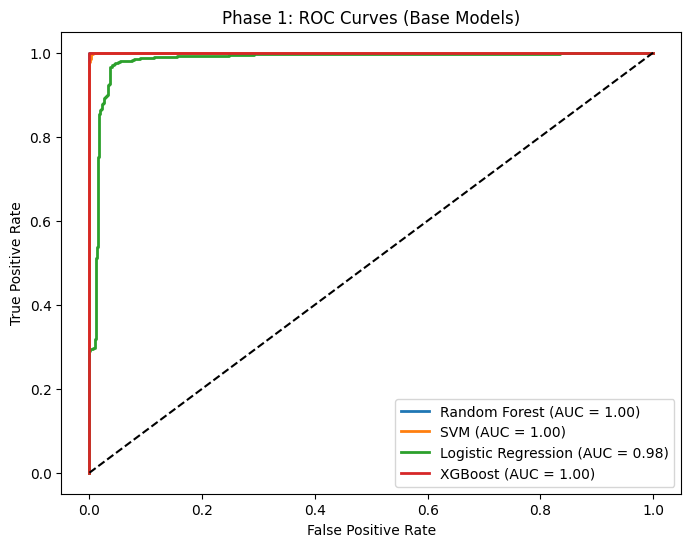

In [48]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.title("Phase 1: ROC Curves (Base Models)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Phase 2 : Features Selection

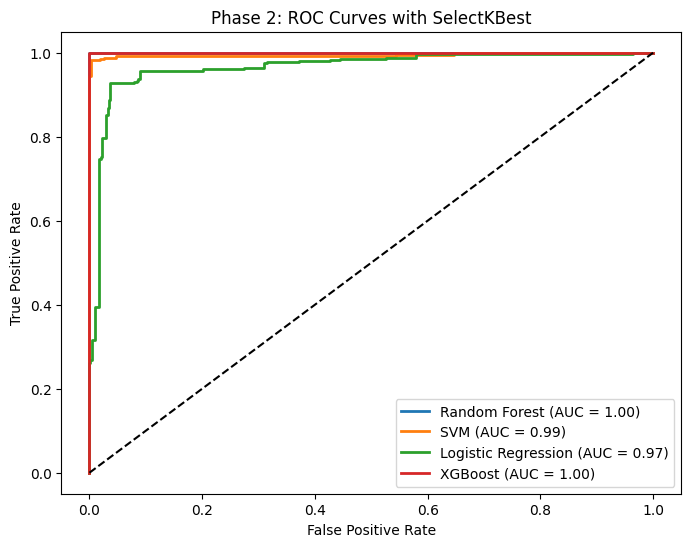

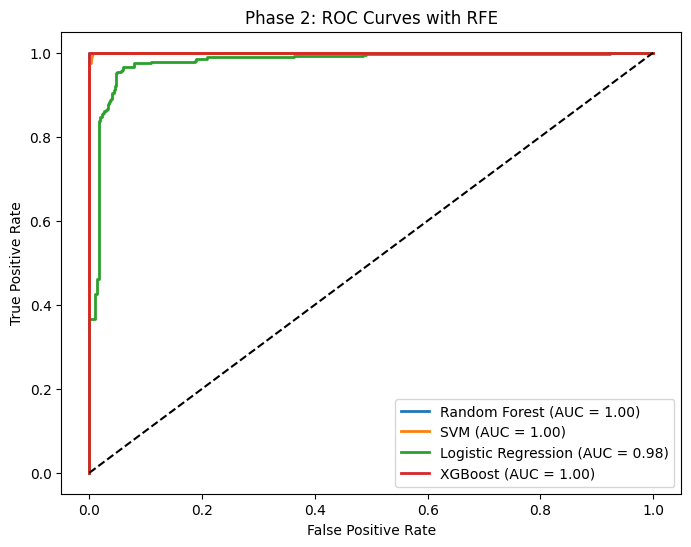

In [49]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# --- SelectKBest ---
kbest = SelectKBest(score_func=f_classif, k=10)
X_new = kbest.fit_transform(X, y)

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
    X_new, y, test_size=0.2, random_state=42, stratify=y
)

# ROC Curves with SelectKBest
plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_train_fs, y_train_fs)
    y_proba = model.predict_proba(X_test_fs)[:,1]
    fpr, tpr, _ = roc_curve(y_test_fs, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.title("Phase 2: ROC Curves with SelectKBest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# --- RFE ---
rfe_selector = RFE(RandomForestClassifier())
X_rfe = rfe_selector.fit_transform(X, y)

X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(
    X_rfe, y, test_size=0.2, random_state=42, stratify=y
)

# ROC Curves with RFE
plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_train_rfe, y_train_rfe)
    y_proba = model.predict_proba(X_test_rfe)[:,1]
    fpr, tpr, _ = roc_curve(y_test_rfe, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.title("Phase 2: ROC Curves with RFE")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## Phase 3 : Grid Search Hyper parameter

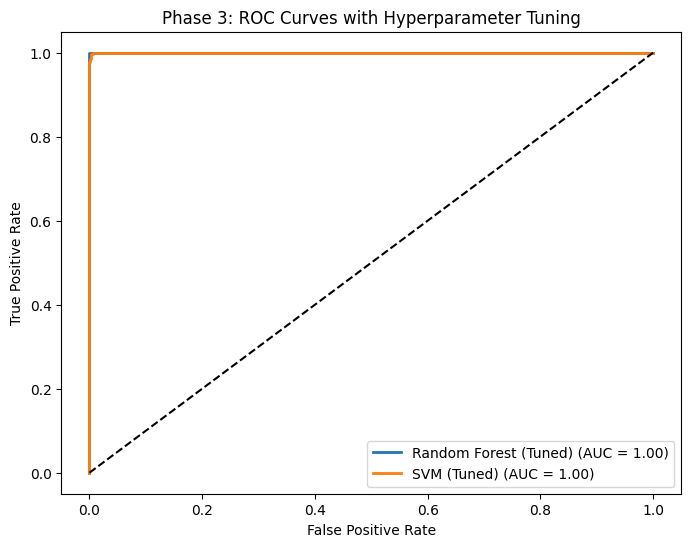

In [50]:
# Example: Random Forest tuning
param_grid_rf = {}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid_rf, cv=3, scoring='roc_auc')
grid_rf.fit(X_train, y_train)

# Example: SVM tuning
param_grid_svm = {"probability": [True]}
grid_svm = GridSearchCV(SVC(probability=True, random_state=42),
                        param_grid_svm, cv=3, scoring='roc_auc')
grid_svm.fit(X_train, y_train)

# ROC plot for tuned models
plt.figure(figsize=(8,6))

for name, model in {
    "Random Forest (Tuned)": grid_rf.best_estimator_,
    "SVM (Tuned)": grid_svm.best_estimator_
}.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.title("Phase 3: ROC Curves with Hyperparameter Tuning")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()